In [38]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
from scipy.optimize import curve_fit

sys.path.insert(1, '../code')
from featurize_and_fit import Featurizer, Fitter
import plotter
import scalars

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sim_name = 'TNG50-4'
sim_name_dark = 'TNG50-4-Dark'
# sim_name = 'TNG100-1'
# sim_name_dark = 'TNG100-1-Dark'
snap_num_str = '099' # z = 0
base_dir = '/scratch/ksf293/equivariant-cosmology/data'

In [3]:
num_star_particles_min = 1
halo_mass_min = 10**10.8
halo_mass_min_str = '1e10.8'
halo_mass_max = None
halo_mass_max_str = None
halo_mass_difference_factor = 3.0
subsample_frac = None

In [4]:
y_scalar_feature_name='mass_hydro_subhalo_star'
mass_multiplier = 1e10

In [5]:
featurizer = Featurizer(base_dir, sim_name, sim_name_dark, snap_num_str)
featurizer.load_halo_dicts(num_star_particles_min=num_star_particles_min, 
                           halo_mass_min=halo_mass_min, halo_mass_min_str=halo_mass_min_str, 
                           halo_mass_max=halo_mass_max, halo_mass_max_str=halo_mass_max_str, 
                           halo_mass_difference_factor=halo_mass_difference_factor,
                           subsample_frac=subsample_frac,
                           force_reload=False)
featurizer.set_y_labels(y_scalar_feature_name=y_scalar_feature_name)
feature_dir = f'../data/features/features_{sim_name}/halos{featurizer.halo_tag}'

Halo file ../data/halo_dicts/halo_dicts_TNG50-4_nstarmin1_hmassmin1e10.8_mdifffac3.0.npy exists, loading
1878 halos in matched, selected halo dicts


In [27]:
def featurize_and_setup_fitter(featurizer, n_rbins, m_order_max, x_order_max, v_order_max,
                               y_val_current, uncertainties, 
                               include_eigenvalues=False):
    r_edges = np.linspace(0, 1, n_rbins+1)
    l_arr, p_arr = scalars.get_needed_vec_orders_scalars(x_order_max, v_order_max)
    featurizer.compute_geometric_features(r_edges, l_arr, p_arr, r_units='r200')
    
    feature_tag = f'_mordmax{m_order_max}_xordmax{x_order_max}_vordmax{v_order_max}_rbins{n_rbins}'
    if include_eigenvalues:
        feature_tag += '_eigvals'
    feature_fn = f'{feature_dir}/scalar_features{feature_tag}.npy'
    if os.path.exists(feature_fn):
        featurizer.load_x_scalar_features(feature_fn)
    else:        
        featurizer.compute_scalar_features(m_order_max, x_order_max, v_order_max,
                                           include_eigenvalues=include_eigenvalues)
    fitter = Fitter(featurizer.x_scalar_features, featurizer.y_scalar, 
                    y_val_current, uncertainties=uncertainties)
    return fitter

In [28]:
def fit_and_plot(featurizer, fitter, rms_x=True, log_x=False, log_y=False):
    fitter.split_train_test()
    fitter.scale_and_fit(rms_x=rms_x, log_x=log_x, log_y=log_y)
    fitter.predict_test()

    # Extract arrays and plot
    y_true = fitter.y_scalar_test*mass_multiplier
    y_pred = fitter.y_scalar_pred*mass_multiplier
    msfe_test = np.mean(((y_pred - y_true)/y_true)**2)

    y_train_pred = fitter.predict(fitter.x_scalar_train, fitter.y_val_current_train)*mass_multiplier
    y_train_true = fitter.y_scalar_train*mass_multiplier
    chi2_train = fitter.chi2

    plotter.plot_pred_vs_true(y_true, y_pred, y_train_true, y_train_pred, 
                              fitter, msfe_test, chi2_train, mass_multiplier)

    masses_all = np.array([h['mass_mean200_dark_halo_dm'] for h in featurizer.halo_dicts])*mass_multiplier
    mass = masses_all[fitter.idx_test]
    mass_train = masses_all[fitter.idx_train]

    plotter.plot_pred_vs_mass(mass, y_true, y_pred, mass_train, y_train_true, y_train_pred, 
                  fitter, msfe_test, chi2_train, mass_multiplier)

### Single mass bin

In [8]:
n_rbins = 1
m_order_max = 1
x_order_max = 0 
v_order_max = 0

uncertainty_floor = 2e8/mass_multiplier
uncertainties_01floor = np.sqrt((0.1*featurizer.y_scalar)**2 + uncertainty_floor**2)

y_val_current_const = np.ones(len(featurizer.y_scalar))

In [9]:
fitter = featurize_and_setup_fitter(featurizer, n_rbins, m_order_max, x_order_max, v_order_max,
                                    y_val_current_const, uncertainties_01floor)

Geometric features exist, loading from ../data/features/features_TNG50-4/halos_nstarmin1_hmassmin1e10.8_mdifffac3.0/geometric_features_larr01*_parr01*_rbins1.npy


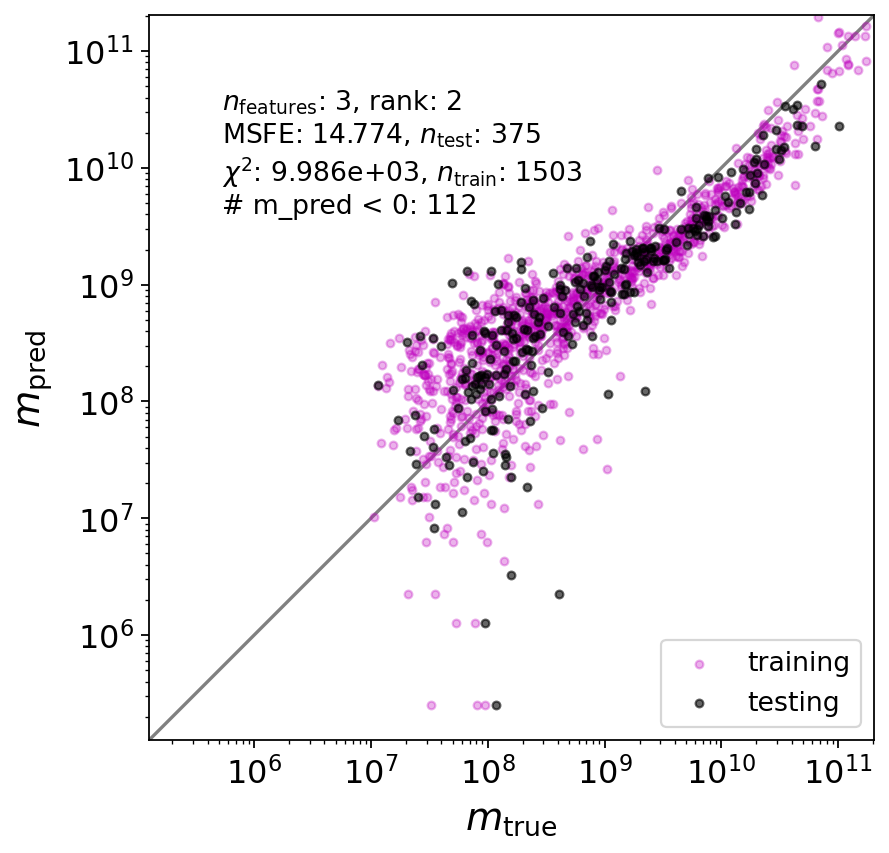

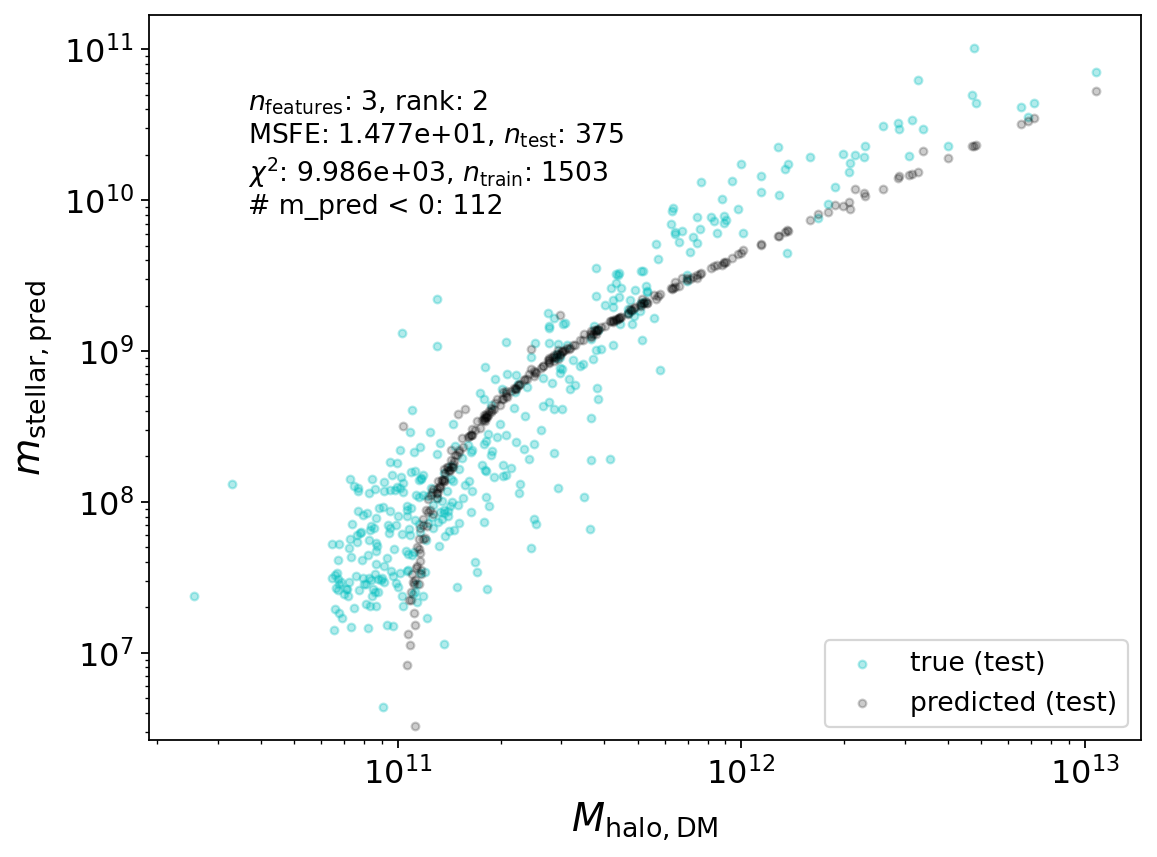

In [10]:
fit_and_plot(featurizer, fitter)

### More bins, higher order in x

In [11]:
n_rbins = 4
m_order_max = 3
x_order_max = 2 
v_order_max = 0

In [12]:
fitter = featurize_and_setup_fitter(featurizer, n_rbins, m_order_max, x_order_max, v_order_max,
                                    y_val_current_const, uncertainties_01floor)

Geometric features exist, loading from ../data/features/features_TNG50-4/halos_nstarmin1_hmassmin1e10.8_mdifffac3.0/geometric_features_larr012_parr0_rbins4.npy


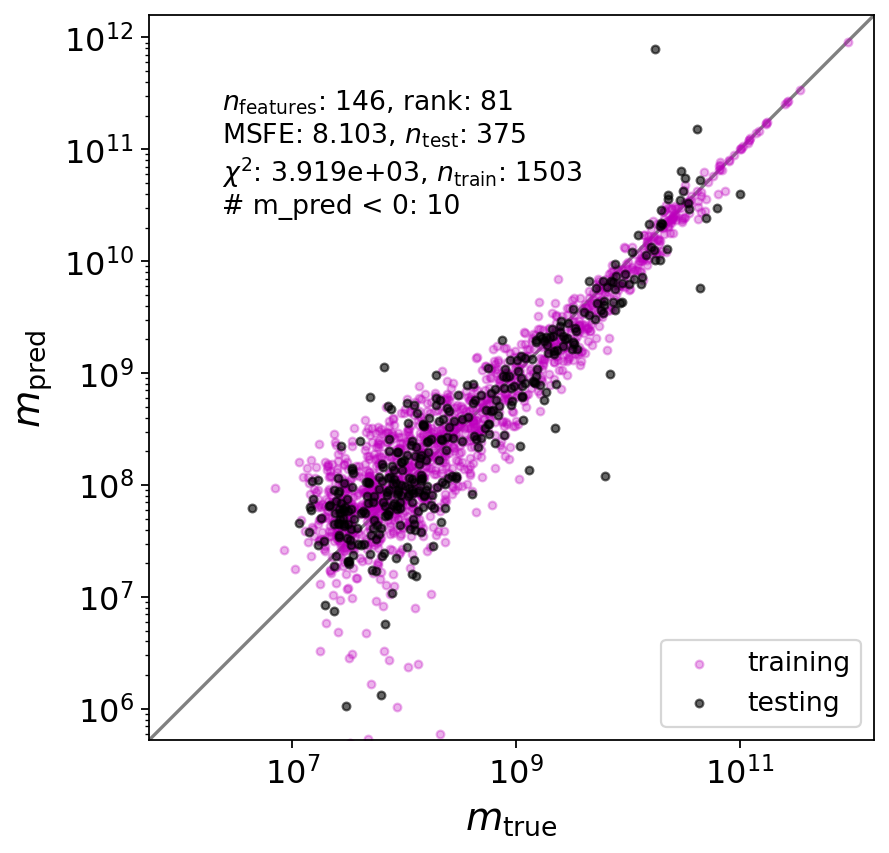

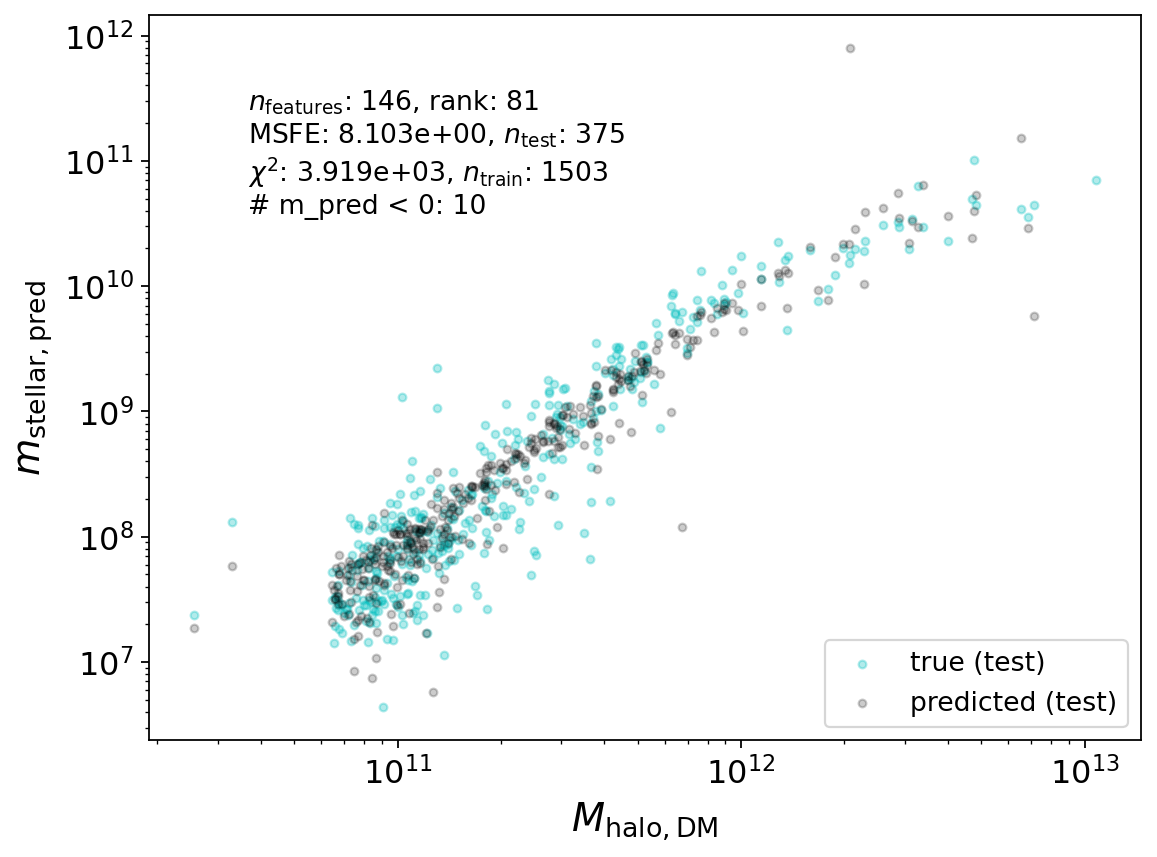

In [13]:
fit_and_plot(featurizer, fitter)

### Include power law in fit (chi-by-eye)

In [40]:
# Inputs to SHMR broken power law:
# N: the normalization of the SHM ratio 
# M1: a characteristic mass 
# β and γ: indicate the behavior of m/M at the low and high-mass ends
def broken_power_law(M200, N=0.01, M1=1e12/mass_multiplier, beta=1.5, gamma=0.4):
    return M200*2*N/((M200/M1)**(-beta) + (M200/M1)**gamma)

In [15]:
m200_halo = np.array([h['mass_mean200_dark_halo_dm'] for h in featurizer.halo_dicts])
y_val_current_powerlaw_byeye = broken_power_law(m200_halo)

In [16]:
fitter = featurize_and_setup_fitter(featurizer, n_rbins, m_order_max, x_order_max, v_order_max,
                                    y_val_current_powerlaw_byeye, uncertainties_01floor)

Geometric features exist, loading from ../data/features/features_TNG50-4/halos_nstarmin1_hmassmin1e10.8_mdifffac3.0/geometric_features_larr012_parr0_rbins4.npy


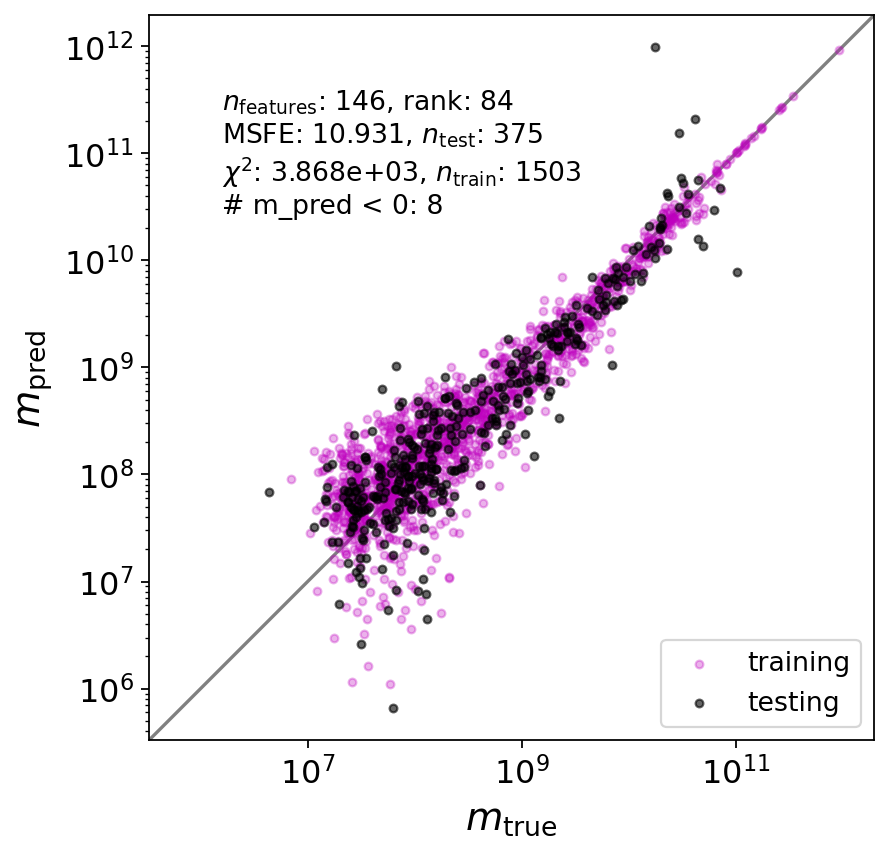

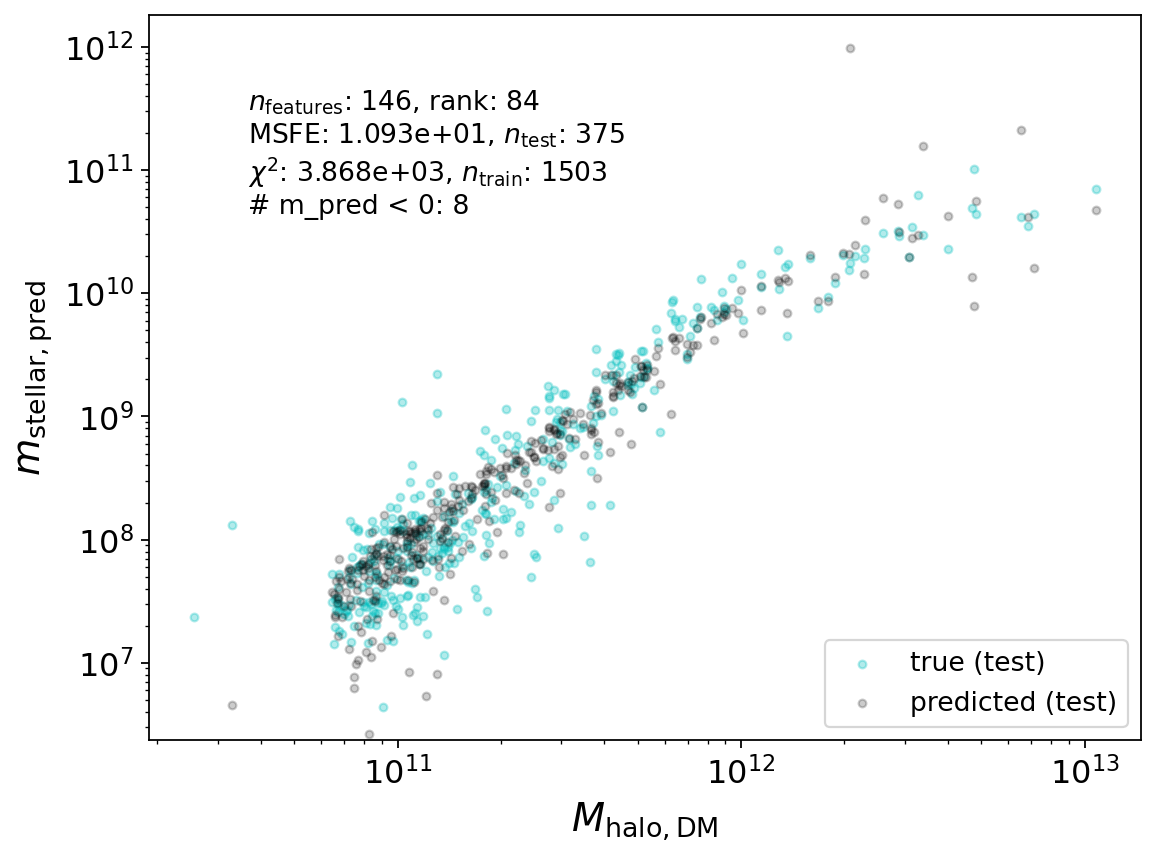

In [17]:
fit_and_plot(featurizer, fitter)

### Improved uncertainty model

In [18]:
logmstellar_bins = np.linspace(8.5, 11, 6)
logmstellar_bins = np.array([5] + list(logmstellar_bins) + [13])
# added estimates on either end
stdev_dict = {'TNG50-4': np.array([0.4, 0.28, 0.23, 0.12, 0.05, 0.04, 0.04]), # epsilon=4, similar to tng50-4
              'TNG100-1': np.array([0.15, 0.08, 0.06, 0.04, 0.03, 0.04, 0.04]), # epsilon=1, similar to tng100-1
             }

logyscalar = np.log10(featurizer.y_scalar*mass_multiplier)
idxs_mbins = np.digitize(logyscalar, logmstellar_bins)

stdevs = stdev_dict[sim_name][idxs_mbins-1]
uncertainties_genel2019 = stdevs * featurizer.y_scalar * np.log(10.0)
# hack to deal with 0-stellar-mass objects
uncertainties_genel2019[uncertainties_genel2019==0] = stdev_dict[sim_name][0] * 10**logmstellar_bins[0]/mass_multiplier

Text(0, 0.5, '$M_\\mathrm{stellar}$')

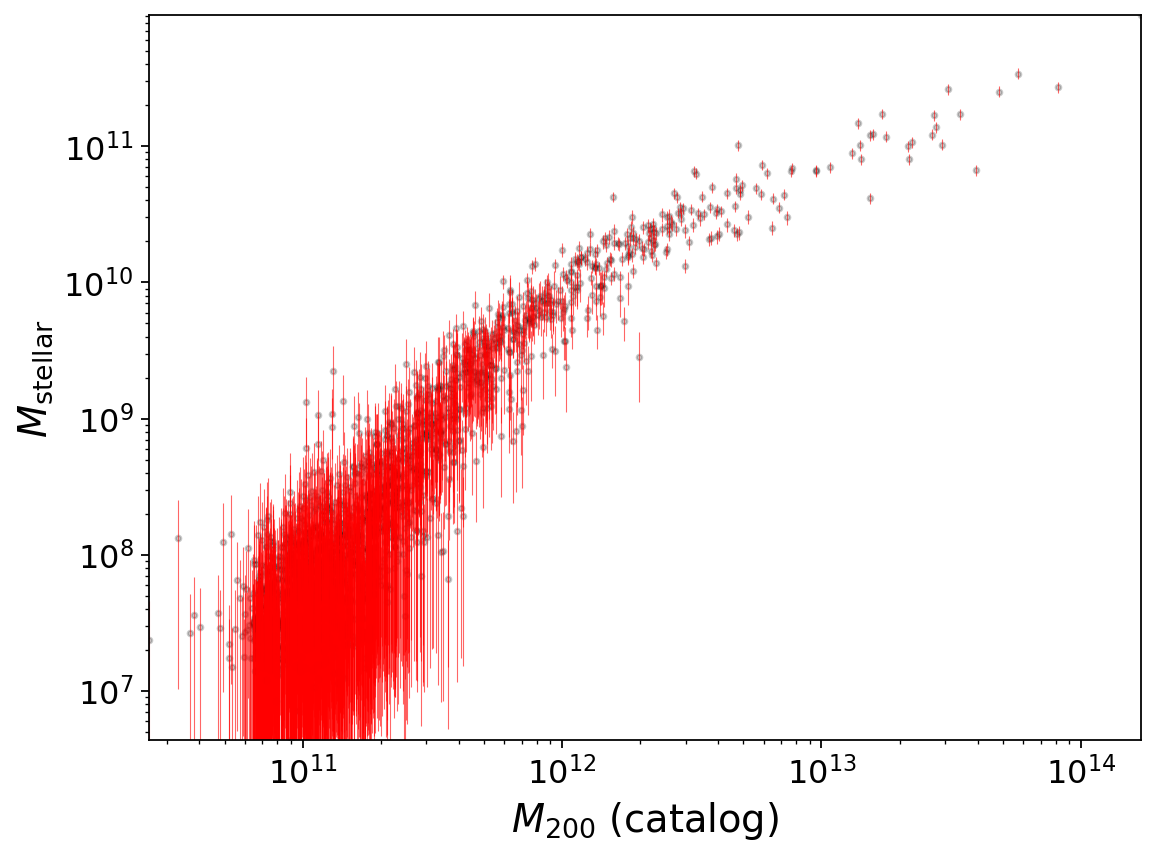

In [19]:
plt.figure(figsize=(8,6))

mdm = m200_halo*mass_multiplier
mstellar = featurizer.y_scalar*mass_multiplier
plt.scatter(mdm, mstellar, color='k', s=6, alpha=0.2)
plt.errorbar(mdm, mstellar, yerr=uncertainties_genel2019*mass_multiplier, 
             color='red', lw=0, elinewidth=0.5, alpha=0.6)

plt.xscale('log')
plt.yscale('log')
xlim = min(mdm), max(mdm)
plt.xlim(xlim)
ylim = min(mstellar), max(mstellar)
plt.ylim(ylim)

plt.xlabel(r'$M_\mathrm{200}$ (catalog)')
plt.ylabel(r'$M_\mathrm{stellar}$')

In [29]:
fitter = featurize_and_setup_fitter(featurizer, n_rbins, m_order_max, x_order_max, v_order_max,
                                    y_val_current_powerlaw_byeye, uncertainties_genel2019)

Geometric features exist, loading from ../data/features/features_TNG50-4/halos_nstarmin1_hmassmin1e10.8_mdifffac3.0/geometric_features_larr012_parr0_rbins4.npy


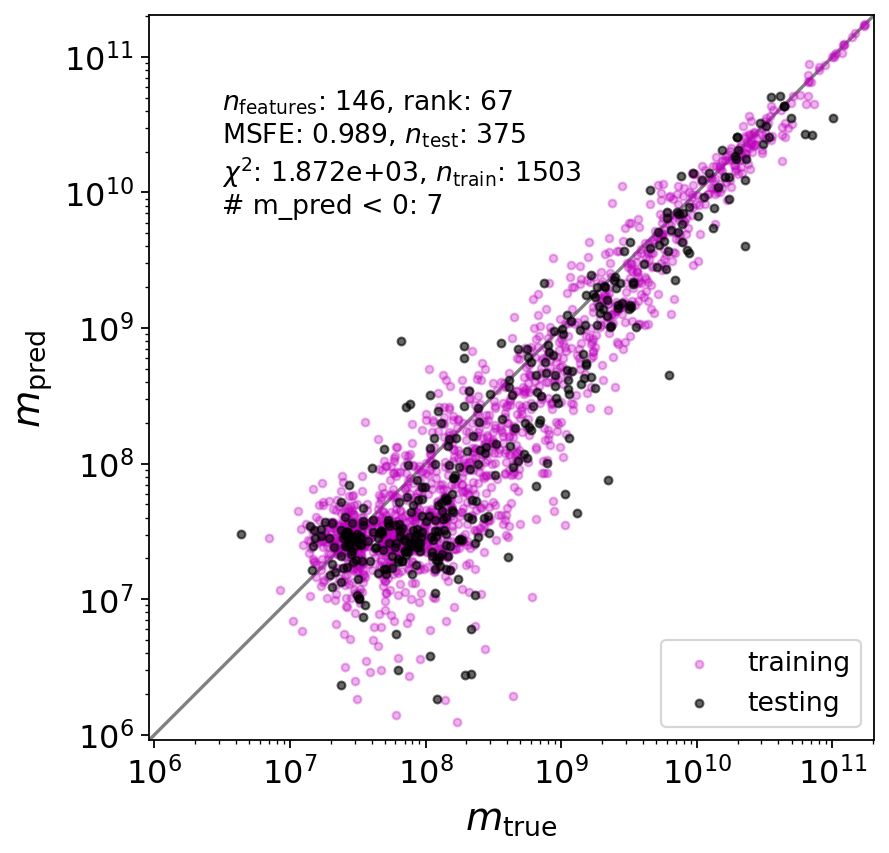

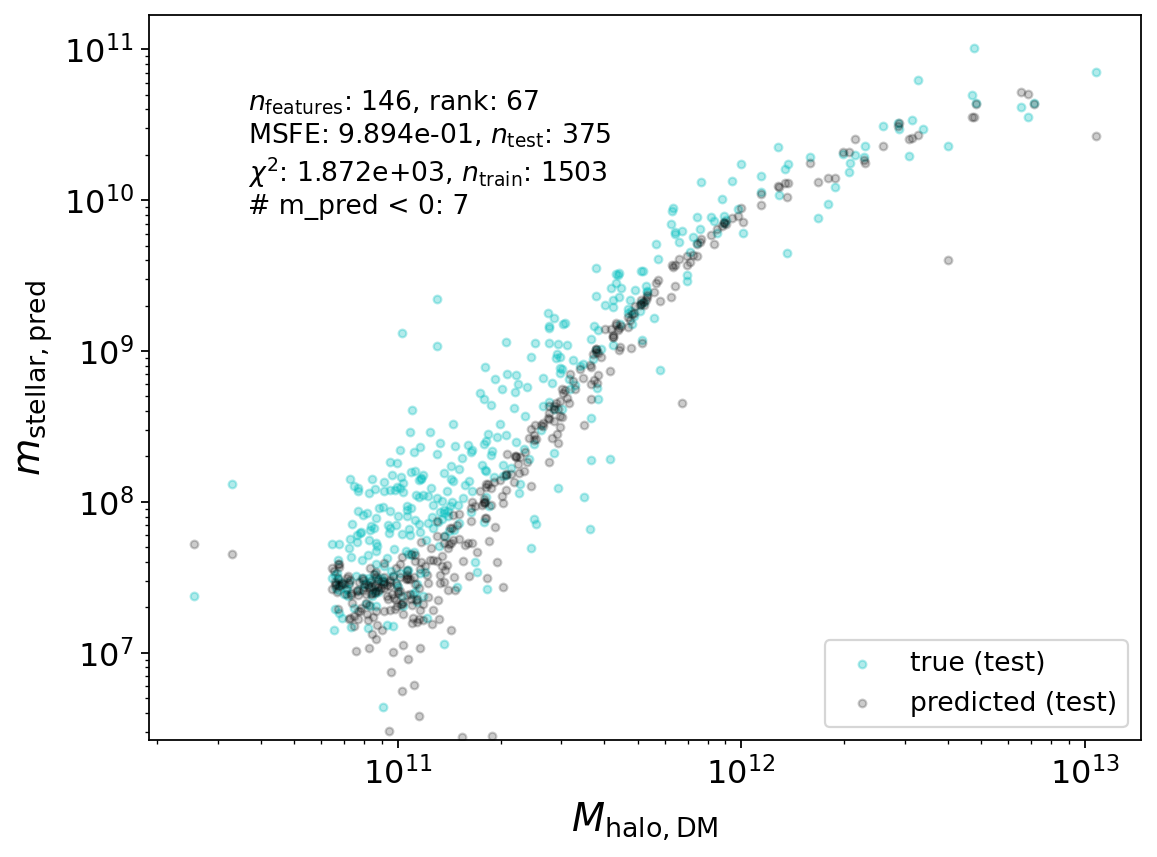

In [30]:
fit_and_plot(featurizer, fitter)

### Improved powerlaw model: fit

In [41]:
p0 = [0.01, 1e12/mass_multiplier, 1.5, 0.4]
bounds = [[0]*len(p0), [np.inf]*len(p0)]
popt, _ = curve_fit(broken_power_law, m200_halo, featurizer.y_scalar, sigma=uncertainties_genel2019, 
                    bounds=bounds, p0=p0)
y_val_current_powerlaw_fit = broken_power_law(m200_halo, *popt)

In [42]:
fitter = featurize_and_setup_fitter(featurizer, n_rbins, m_order_max, x_order_max, v_order_max,
                                    y_val_current_powerlaw_fit, uncertainties_genel2019)

Geometric features exist, loading from ../data/features/features_TNG50-4/halos_nstarmin1_hmassmin1e10.8_mdifffac3.0/geometric_features_larr012_parr0_rbins4.npy


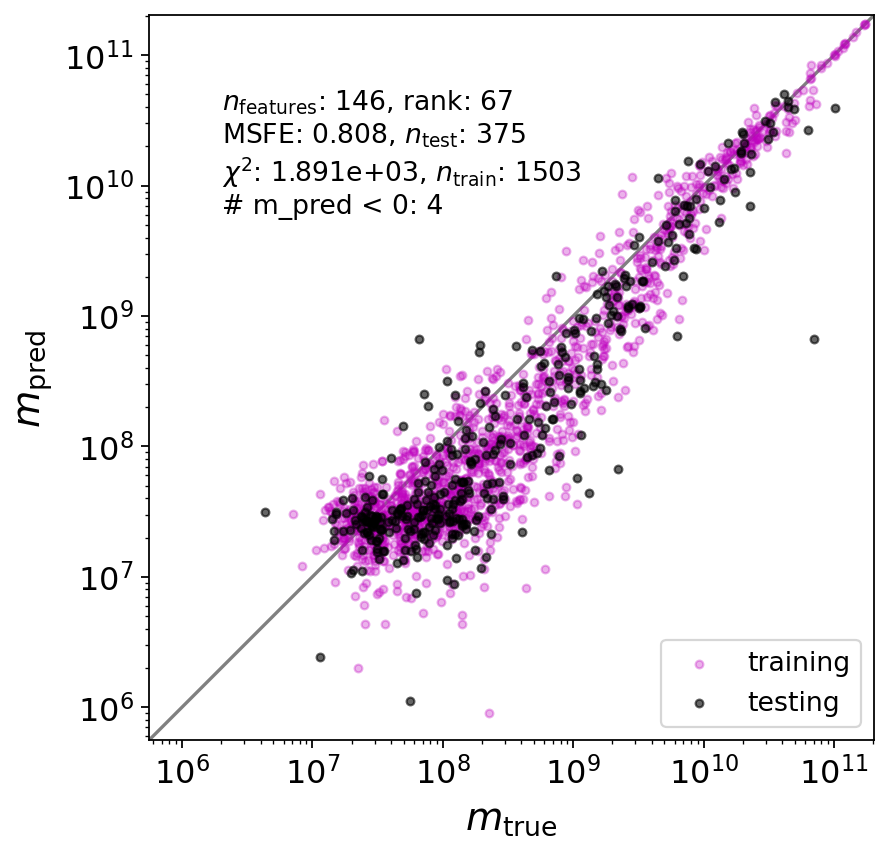

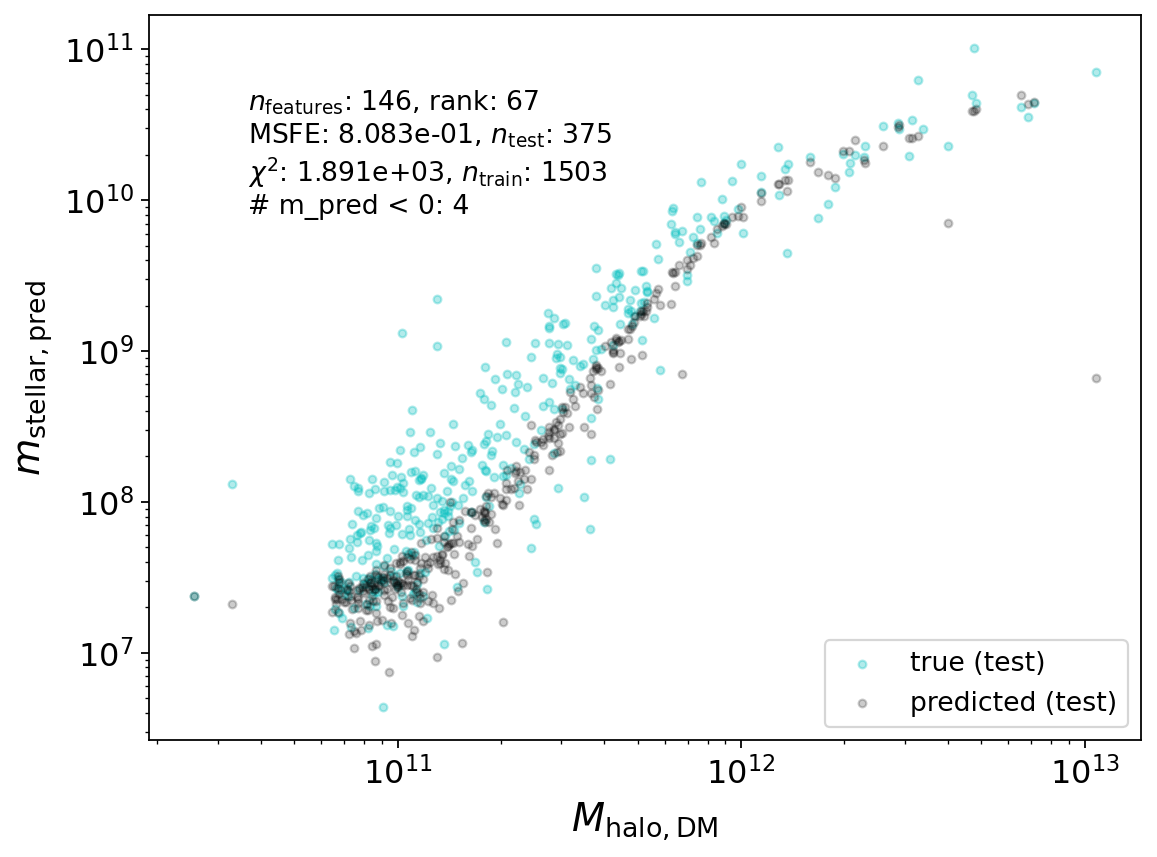

In [43]:
fit_and_plot(featurizer, fitter)

### Include eigenvalues of tensors

In [31]:
include_eigenvalues = True

In [34]:
fitter = featurize_and_setup_fitter(featurizer, n_rbins, m_order_max, x_order_max, v_order_max,
                                    y_val_current_powerlaw_byeye, uncertainties_genel2019,
                                    include_eigenvalues=include_eigenvalues)

Geometric features exist, loading from ../data/features/features_TNG50-4/halos_nstarmin1_hmassmin1e10.8_mdifffac3.0/geometric_features_larr012_parr0_rbins4.npy


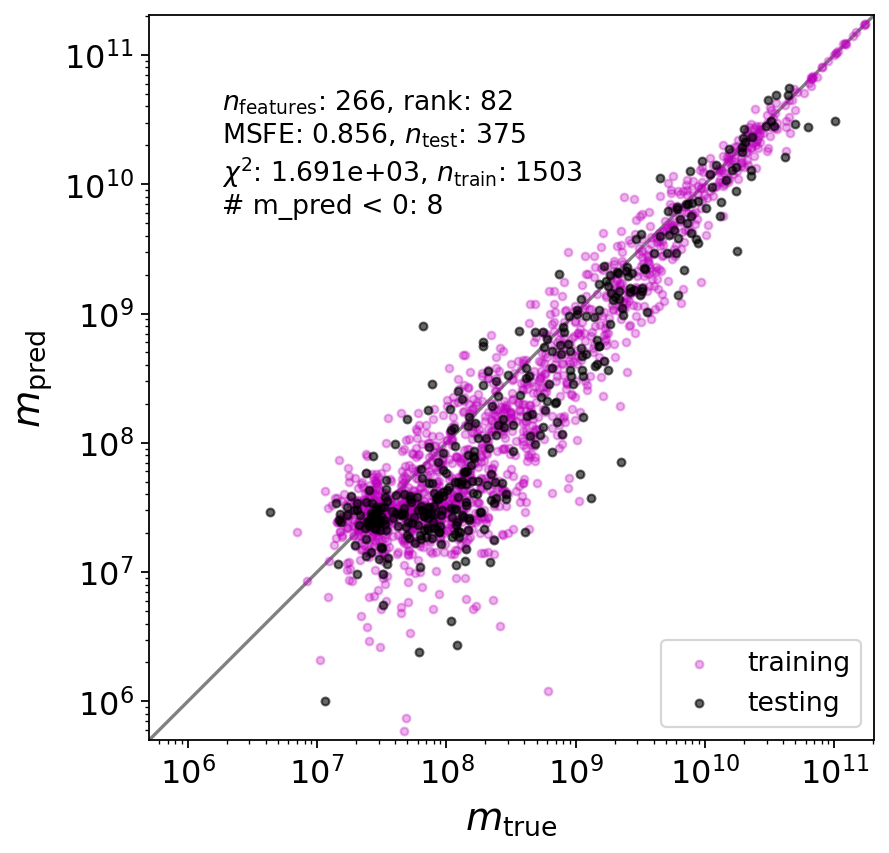

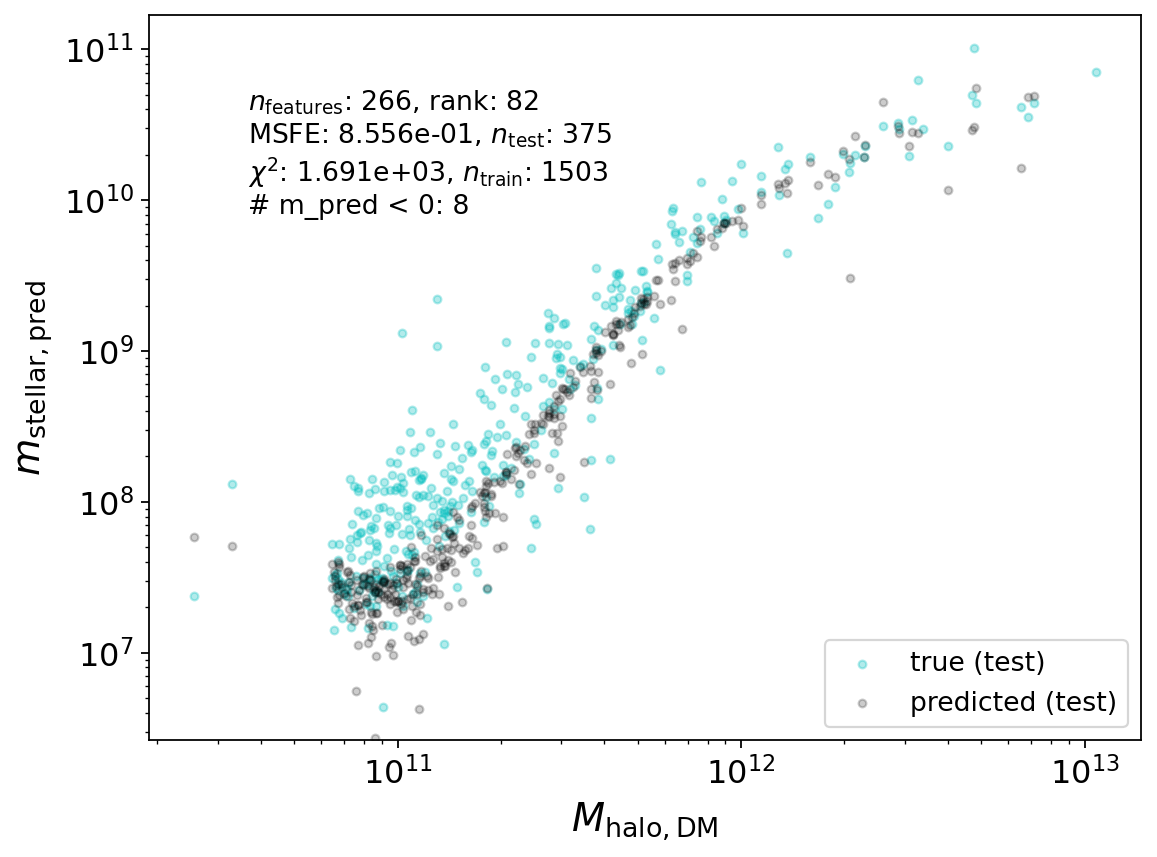

In [35]:
fit_and_plot(featurizer, fitter)

## Visualize features

In [75]:
def plot_feature_vs_mass(masses, featurizer, i_feat, feat_label=None, 
                         log_y=True, x_label=None):
    if feat_label is None:
        feat_label = f'feature {i_feat}'
        
    fig = plt.figure(figsize=(4,3))
    x_feat = featurizer.x_scalar_features[:,i_feat] * mass_multiplier
    plt.scatter(masses, x_feat, color='k', s=6, alpha=0.2)
    plt.xscale('log')
    plt.yscale('log')
    xlim = np.min(masses), np.max(masses)
    plt.xlim(xlim)
    if log_y:
        ylim = np.min(x_feat[x_feat>0]), np.max(x_feat[x_feat>0])
        plt.ylim(ylim)
        feat_label = f'log({feat_label})'
    
    plt.xlabel(x_label)
    plt.ylabel(feat_label)

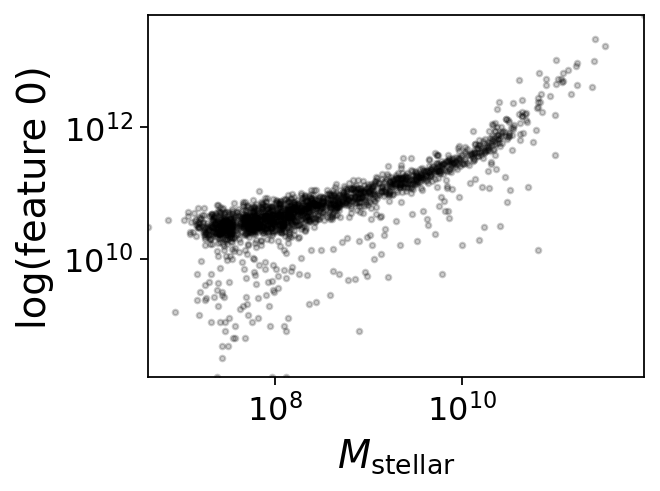

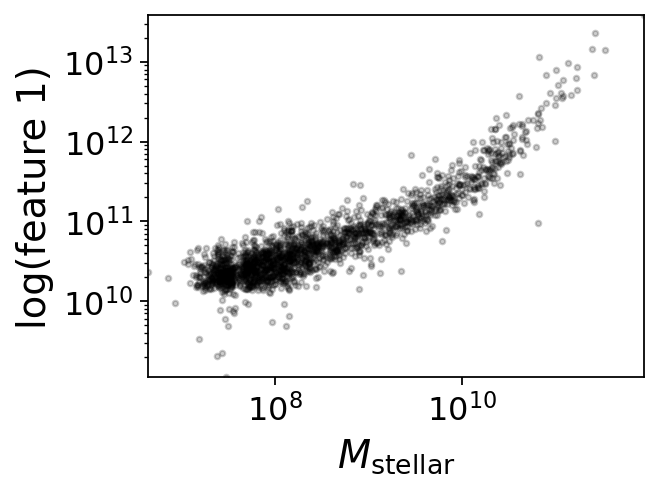

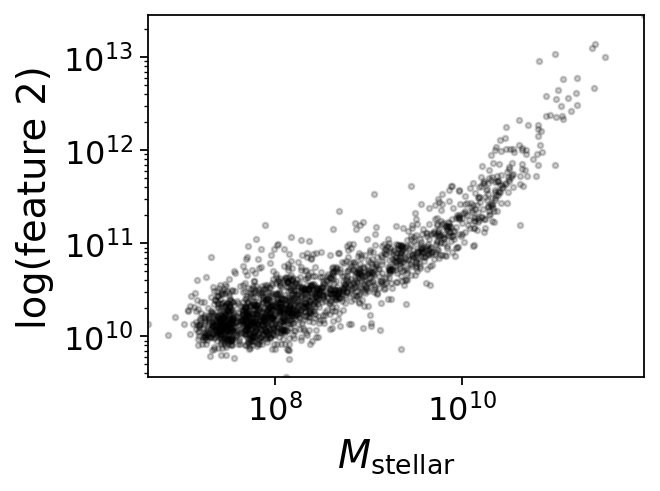

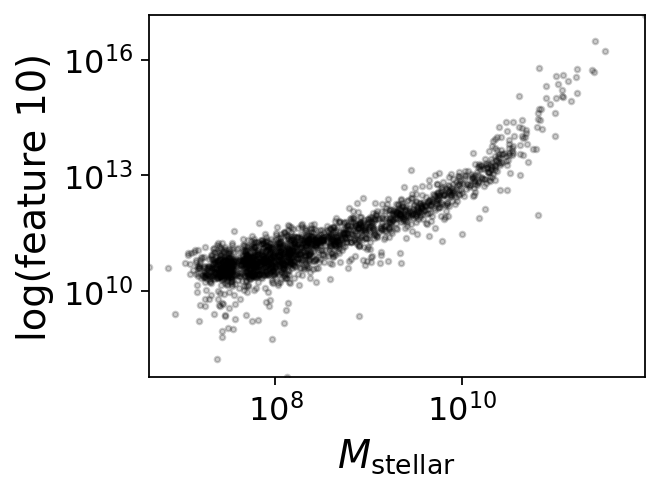

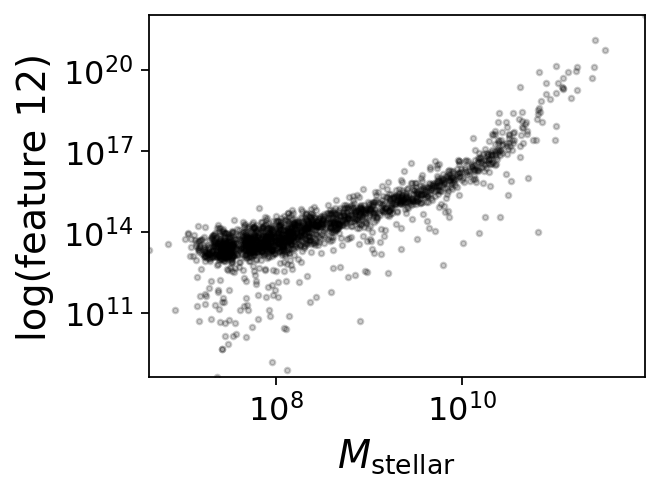

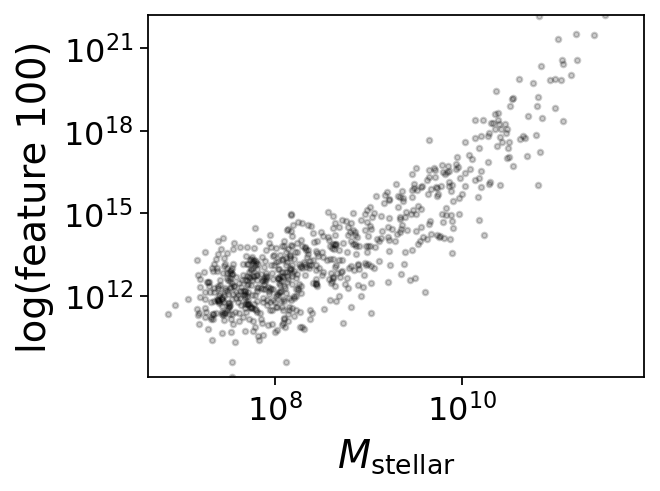

In [76]:
i_feats = [0, 1, 2, 10, 12, 100]
for i_feat in i_feats:
    plot_feature_vs_mass(featurizer.y_scalar*mass_multiplier, featurizer, i_feat=i_feat, 
                         x_label=r'$M_\mathrm{stellar}$')